In [2]:
from sklearn.datasets import fetch_openml

# import MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# print the keys of the dataset
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn have a dictionary structure:
* A **DESCR** key describing the dataset.
* A **data** key containing an array (*dataframe?*) with one row per instance and once column per feature.
* A **target** key containing an array (*series?*) with the labels.

In [30]:
import numpy as np

# assign data to X and target to y
X, y = mnist["data"], mnist["target"]

# print the shape of X and y
X.shape, y.shape

# convert X and y to arrays
X = X.values
y = y.values

# check their type
type(X), type(y)

(numpy.ndarray, pandas.core.arrays.categorical.Categorical)

There are 70,000 images (rows) and 784 features (columns). 

Each feature represents 1 pixel's intensity (1 image = 28 x 28 pixels), from 0 (white) to 255 (black).

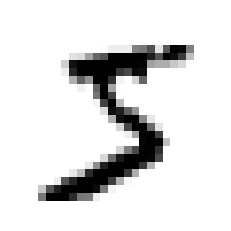

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# check one digit from the dataset
some_digit = X[0]

# reshape image to 28 x 28 for a more intuitive representation
some_digit_image = some_digit.reshape(28, 28)

# show image
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [32]:
# check its label
y[0]

'5'

Notice that y is of type object.

In [34]:
# check the data type of y
type(y)

pandas.core.arrays.categorical.Categorical

More info on numpy data types [here](https://numpy.org/doc/stable/user/basics.types.html).

In [41]:
# convert y to integer
y = y.astype(np.uint8)

# check type of the y array
y.dtype

dtype('uint8')

Split the data into test and training sets.

In [42]:
# assign 60_000 rows for training and 10_000 for testing
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

<a name="BinaryClassification"> </a>
# Training a Binary Classifier

Train the **5-detector**, capable of distinguishing between just 2 classes: 5 and not-5.

In [44]:
# True for all 5s, False for all others
y_train_5 = (y_train == 5)

y_test_5 = (y_test == 5)

In [46]:
# train a Stochastic Gradient Descent (SGD) Classifier
from sklearn.linear_model import SGDClassifier

# create an SGDC instance
sgd_clf = SGDClassifier(random_state=42)

# fit SGDC on training data
sgd_clf.fit(X_train, y_train_5)

# make predictions
sgd_clf.predict([some_digit])

array([ True])

This was indeed a 5!

In [50]:
y[0]

5